# General Analysis on US accidents

## Analyze with respect to impact on time distribution and weather condition

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset

In [3]:
#read the .csv file to get the data
data = pd.read_csv('./US_Accidents_Dec19.csv')

### Define Functions

In [5]:
def which_day(date_time):
    '''
    To find out which weekday according to given timestamp
    input: datetime string with the format of 'yyyy-mm-dd hh:mm:ss'
    return: nth day of the week
    '''

    assert isinstance(date_time, str)
    assert len(date_time) > 0

    from datetime import datetime
    import calendar
    import pandas as pd

    try:
        if type(date_time) is str:
            my_string=date_time.split(' ')[0]
            my_date = datetime.strptime(my_string, "%Y-%m-%d")
            return my_date.weekday()
        else:
            raise Exception("'date_time' has unexpected data type, it is expected to be a sting")

    except Exception as e:
        print(e)

### Analyze on different weather conditions

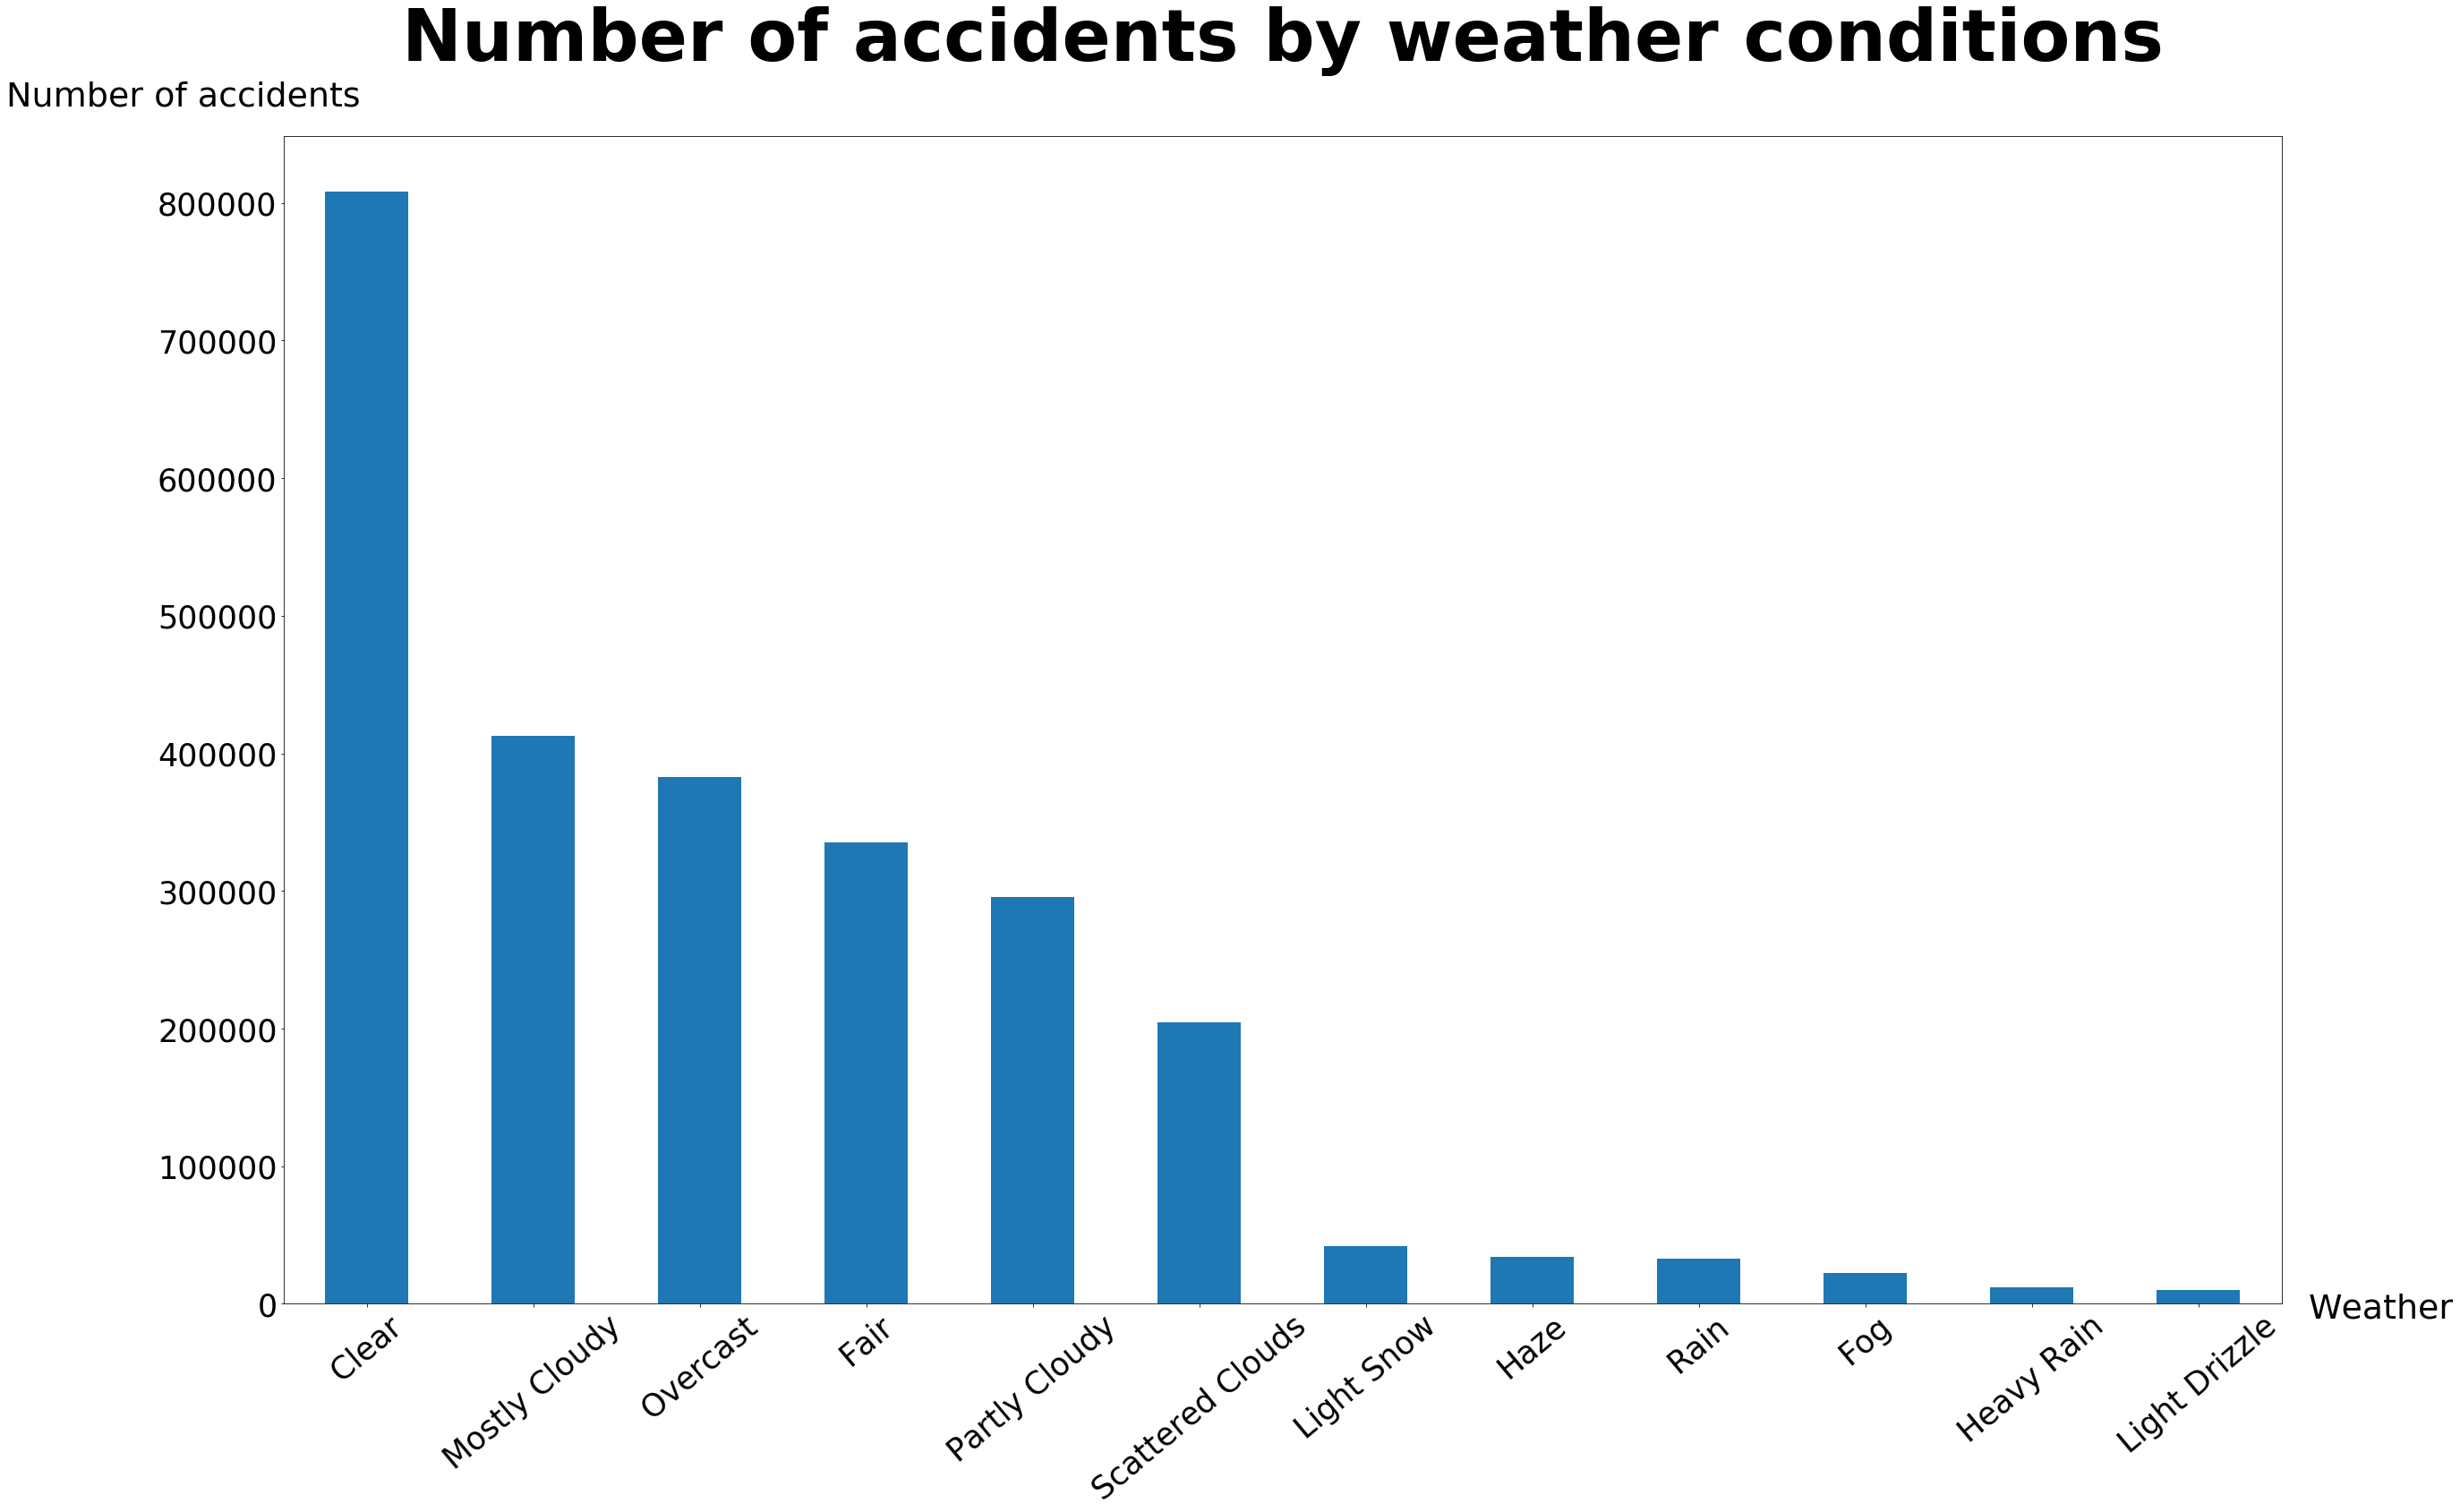

In [6]:
#Visulize the weather condition data through a horizontal bar plot
Weather = data.Weather_Condition.value_counts()
Weather_plt=Weather[['Clear','Mostly Cloudy','Overcast','Fair','Partly Cloudy','Scattered Clouds','Light Snow','Haze','Rain','Fog','Heavy Rain','Light Drizzle']]
plt.figure(figsize=(24, 18))
ax = Weather_plt.plot(kind="bar", rot=40, figsize=(40,24), fontsize=35, color='C0')
ax.set_xlabel("Weather", rotation = 0, fontsize=38)
ax.set_ylabel("Number of accidents", rotation = 0, fontsize=38)
ax.xaxis.set_label_coords(1.05,0.01)
ax.yaxis.set_label_coords(-0.05,1.02)
plt.title("Number of accidents by weather conditions", fontdict = {'fontsize': 80}, weight = 'bold', y=1.06)
plt.savefig('weather_US_horizontal.png', transparent=False)
plt.show()

### Analyze on general time distribution versus number of accidents

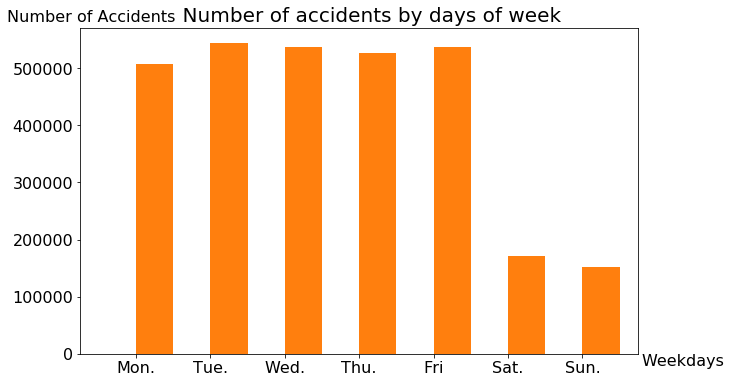

In [7]:
# use the which_day function to find the corresponding weekday
nth_day=[]
date_time=[dt for dt in data['Start_Time']]
for i in range(len(date_time)):
    nth_day.append(which_day(date_time[i]))

# add four new columns 'year', 'month', 'hour', 'weekday'
data['year'] = pd.DatetimeIndex(data['Start_Time']).year
data['month'] = pd.DatetimeIndex(data['Start_Time']).month
data['hour'] = pd.DatetimeIndex(data['Start_Time']).hour
data['weekday']=nth_day

#split data into weekdays and weekends
wday_filt = (data['weekday'].isin([0, 1, 2, 3, 4]))
weekend_filt = (data['weekday'].isin([5, 6]))
data_workday = (data.loc[wday_filt])[['hour']]
data_weekend = (data.loc[weekend_filt])[['hour']]

#plot out accidant data with respect to the weekday distribution
dt_weekday=data.groupby(['weekday'], as_index=False).count().iloc[:,:2]
ax=dt_weekday.plot(kind='bar',rot=0,width=1.0,figsize=(10, 6),fontsize=16,legend=None)
xtick_labels=['Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri', 'Sat.', 'Sun.']
ax.set_xticks(list(dt_weekday.index))
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('Weekdays',rotation=0, fontsize=16)
ax.set_ylabel('Number of Accidents',rotation=0, fontsize=16)
ax.set_title('    Number of accidents by days of week', fontsize=20)
ax.xaxis.set_label_coords(1.08,0.00)
ax.yaxis.set_label_coords(0.02,1.01)
plt.savefig('#Accidents_days_of_week.png',transparent=False)
plt.show()

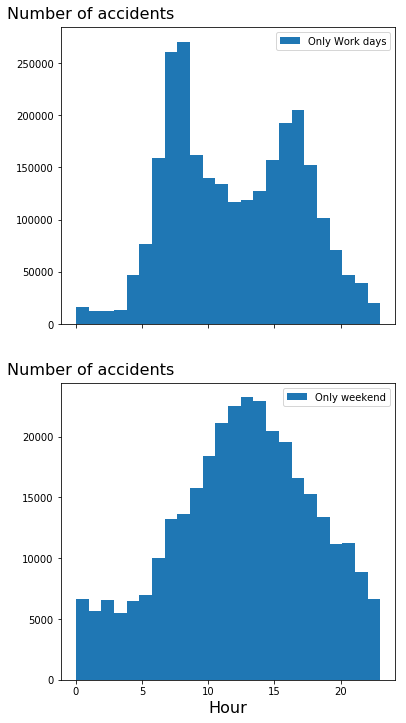

In [8]:
#plot out distributon divided into weekdays and weekends
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(6, 12),sharex=True)
ax0,ax1=axes.flatten()
kwargs = dict(bins=24,density=False,histtype='stepfilled',linewidth=3)
ax0.hist(list(data_workday['hour']),**kwargs,label='Only Work days')
ax0.set_ylabel('Number of accidents',fontsize=16,rotation=0)
ax0.yaxis.set_label_coords(0.09,1.02)
ax1.hist(list(data_weekend['hour']),**kwargs,label='Only weekend')
ax1.set_ylabel('Number of accidents',fontsize=16,rotation=0)
ax1.set_xlabel('Hour',fontsize=16)
ax1.yaxis.set_label_coords(0.09,1.02)
ax0.legend(); ax1.legend()
plt.savefig('hourly_distribution_US.png',transparent=True)
plt.show()

# Analysis on US accidents with focus on California State
## Analyze the relationship between weather and severity

### Import Libraries

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Load Dataset

In [10]:
file = "./US_Accidents_Dec19.csv"
df = pd.read_csv(file)

### Function Definitions

In [29]:
def plot_bar_charts(data, title, plot_kind="bar", normal=False, rotation=0, stacked = False, figsize=None, 
    plot_fontsize=None, cmap = None, xlabel_name=None, xlabel_rotation=0, xlabel_fontsize=None, 
    xlabel_weight=None, ylabel_name=None, ylabel_rotation=0, ylabel_fontsize=None, ylabel_weight=None, 
    xlabel_coordinate=None, ylabel_coordinate=None, title_fontsize=None, title_weight=None, title_y=None, 
    ifledgend=False, ledgend_name=None, ledgend_fontsize=None, ledgend_location=None, bbox_to_anchor=None, 
    frameon=False):
    """
    Plot a value-count chart for different columns in the dataframe
    Args:
        data: Input dataframe or series
        title: Title for printed chart
        plot_kind: "bar" stands for vertical bar charts and "barh" stands for horizontal bar charts
        normal: If we want to normalize the counted value as percentage of total number
        rotation: Rotation for labels, default 0
        stacked: If there is more than 1 column to be plot in the dataframe, stack those columns or not
        figsize: A tuple for desired plotted chart
        plot_fontsize: Font size for labels
        cmap: Desired color map for plot
        xlabel_name: Label for x axis on plotted chart
        xlabel_rotation: Rotation for name of x axis, default 0
        xlabel_fontsize: Font size for name of x axis
        xlabel_weight: Different wight on name of x axis
        ylabel_name: Label for y axis on plotted chart
        ylabel_rotation: Rotation for name of y axis, default 0
        ylabel_fontsize: Font size for name of y axis
        ylabel_weight: Different wight on name of y axis
        xlabel_coordinate: Coordinate of x label
        ylabel_coordinate: Coordinate of y label
        title_fontsize: Font size for title
        title_weight: Different weight on title
        title_y: Adjust height of title
        ifledgend: If we need to mark ledgend or not
        ledgend_name: A tuple contains desired showed ledgend name
        ledgend_fontsize: Font size for ledgend
        ledgend_location: Where to put the ledgend box
        bbox_to_anchor: Coordinate of bound box for ledgend
        frameon: Show the bounding box frame or not
    Return:
        None: We plot a chart when the function is called, nothing to be return
    """
    assert isinstance(data, pd.DataFrame) or isinstance(data, pd.Series)
    assert isinstance(title, str)
    assert isinstance(plot_kind, str)
    assert isinstance(normal, bool)
    assert isinstance(rotation, int)
    assert isinstance(stacked, bool)
    if figsize: assert isinstance(figsize, tuple)
    if plot_fontsize: assert isinstance(plot_fontsize, int)
    if cmap: assert isinstance(cmap, str)
    if xlabel_name: assert isinstance(xlabel_name, str)
    assert isinstance(xlabel_rotation, int)
    if xlabel_fontsize: assert isinstance(xlabel_fontsize, int)
    if xlabel_weight: assert isinstance(xlabel_weight, str)
    if ylabel_name: assert isinstance(ylabel_name, str)
    assert isinstance(ylabel_rotation, int)
    if ylabel_fontsize: assert isinstance(ylabel_fontsize, int)
    if ylabel_weight: assert isinstance(ylabel_weight, str)
    if xlabel_coordinate: assert isinstance(xlabel_coordinate, tuple)
    if ylabel_coordinate: assert isinstance(ylabel_coordinate, tuple)
    if title_fontsize: assert isinstance(title_fontsize, int)
    if title_weight: assert isinstance(title_weight, str)
    if title_y: assert isinstance(title_y, float)
    assert isinstance(ifledgend, bool)
    if ledgend_name: assert isinstance(ledgend_name, tuple)
    if ledgend_fontsize: assert isinstance(ledgend_fontsize, int)
    if ledgend_location: assert isinstance(ledgend_location, str)
    if bbox_to_anchor: assert isinstance(bbox_to_anchor, tuple)
    assert isinstance(frameon, bool)
    

    #Save and Plot the chart 
    ax = data.plot(kind=plot_kind, stacked=stacked, rot=rotation, figsize=figsize, fontsize=plot_fontsize, cmap=cmap)
    if ifledgend:
        plt.legend(('least', 'less', 'moderate', 'severe'), fontsize = 80, loc='upper right', bbox_to_anchor=(1.12, 1.08), frameon = True)
    ax.set_xlabel(xlabel_name, rotation = xlabel_rotation, fontsize=xlabel_fontsize, weight=xlabel_weight)
    ax.set_ylabel(ylabel_name, rotation = ylabel_rotation, fontsize=ylabel_fontsize, weight=ylabel_weight)
    ax.xaxis.set_label_coords(xlabel_coordinate[0], xlabel_coordinate[1])
    ax.yaxis.set_label_coords(ylabel_coordinate[0], ylabel_coordinate[1])
    plt.title(title, fontdict = {'fontsize': title_fontsize}, weight=title_weight, y=title_y)
    plt.savefig(title, transparent=True)
    plt.show()

### Analyze on weather condition and severity distribution

In [12]:
# Focus on California state
data = df[df["State"] == "CA"]

/Users/User/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


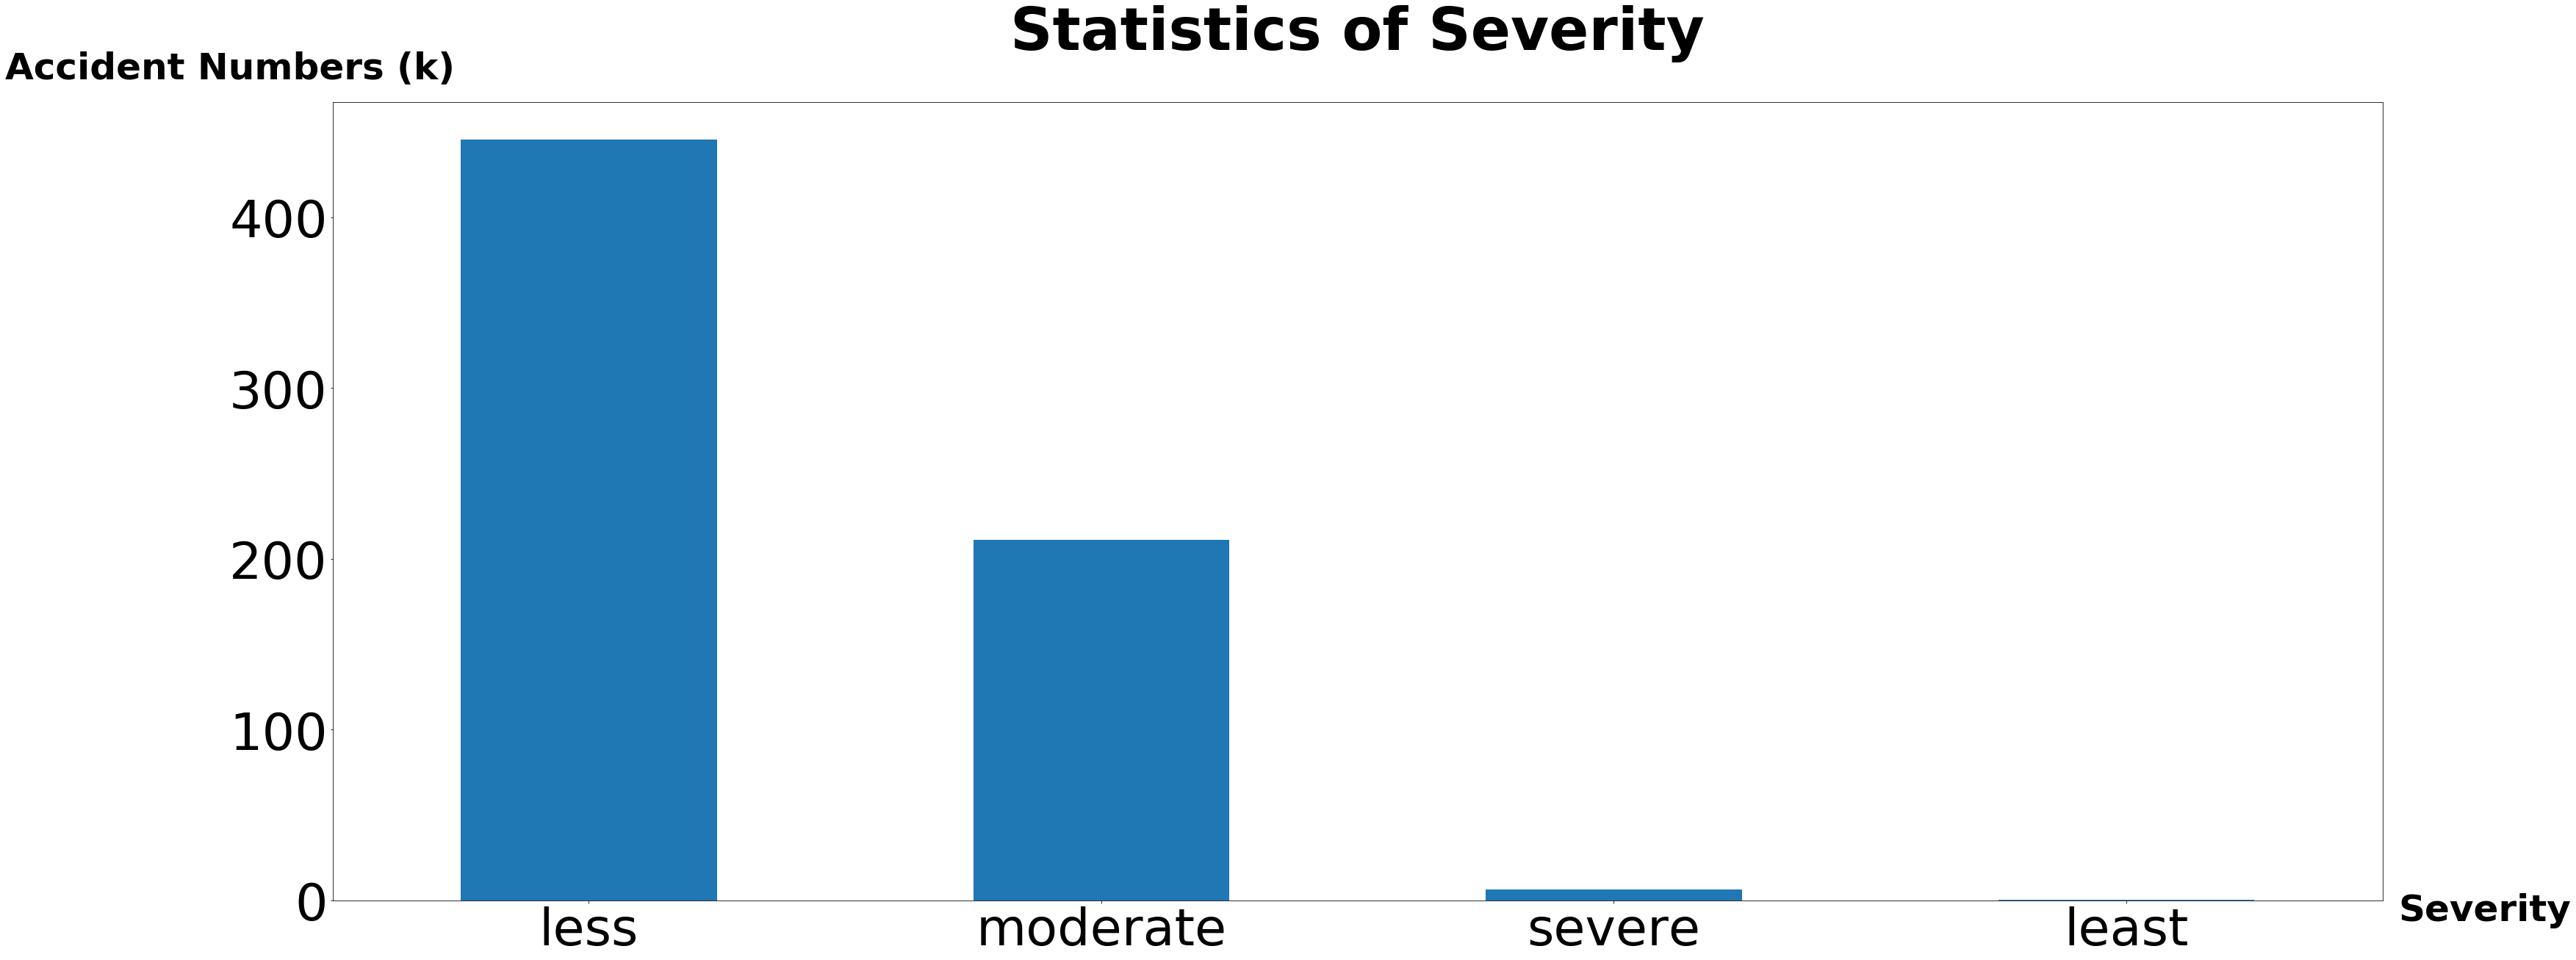

/Users/User/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
#Count total accident numbers under different severity
#Replace the index of "Severity" column from [1, 2, 3, 4] to ['least', 'less', 'moderate', 'severe']
#for a better understanding in plotted chart
data["Severity"] = data["Severity"].replace([1, 2, 3, 4], ['least', 'less', 'moderate', 'severe'])
severity = data["Severity"].value_counts()/1000

#Value counts under different severities
plot_bar_charts(severity, "Statistics of Severity", plot_kind="bar", figsize=(50,20), plot_fontsize=70, 
                xlabel_name="Severity", xlabel_rotation=0, xlabel_fontsize=50, xlabel_weight='bold', 
                ylabel_name="Accident Numbers (k)", ylabel_rotation=0, ylabel_fontsize=50, ylabel_weight='bold', 
                xlabel_coordinate=(1.05,0.01), ylabel_coordinate=(-0.05,1.02), title_fontsize=80, title_weight='bold', title_y=1.06)

#Reverse the index of "Severity" column from ['least', 'less', 'moderate', 'severe'] to [1, 2, 3, 4]
data["Severity"] = data["Severity"].replace(['least', 'less', 'moderate', 'severe'], [1, 2, 3, 4])

In [25]:
#Select desired weather conditions
weather_choosed = ['Blowing Dust', 'Blowing Dust / Windy', 'Blowing Sand', 'Clear', 'Fair', 'Fog / Windy', 
                        'Hail', 'Heavy Drizzle', 'Light Freezing Rain', 'Light Rain', 'Light Snow / Windy', 
                        'Light Snow Showers', 'Mostly Cloudy', 'Thunderstorm', 'Widespread Dust / Windy']

#Construct four lists stand for different severity
#Index order follows order of weather index which is defined above (with alphabet order)
severity_1_by_Weather = []
severity_2_by_Weather = []
severity_3_by_Weather = []
severity_4_by_Weather = []
for i in weather_choosed:
    severity_1_by_Weather.append(data[(data['Severity']==1)&(data['Weather_Condition']==i)].count()['ID'])
    severity_2_by_Weather.append(data[(data['Severity']==2)&(data['Weather_Condition']==i)].count()['ID'])
    severity_3_by_Weather.append(data[(data['Severity']==3)&(data['Weather_Condition']==i)].count()['ID'])
    severity_4_by_Weather.append(data[(data['Severity']==4)&(data['Weather_Condition']==i)].count()['ID'])
print(len(severity_1_by_Weather))

15


In [26]:
#Count total accident numbers under different weather conditions
Weather = data.Weather_Condition.value_counts()

percentage_severity_1 = []
percentage_severity_2 = []
percentage_severity_3 = []
percentage_severity_4 = []

#Calculated the percentage of accident numbers regard to different weather conditions
for i, val in enumerate(weather_choosed):
    percentage_severity_1.append((severity_1_by_Weather[i]/Weather[val])*100)
    percentage_severity_2.append((severity_2_by_Weather[i]/Weather[val])*100)
    percentage_severity_3.append((severity_3_by_Weather[i]/Weather[val])*100)
    percentage_severity_4.append((severity_4_by_Weather[i]/Weather[val])*100)

print(len(percentage_severity_1))

15


In [27]:
#Construct a pandas DataFrame with four lists above
weather_severity_percentage = pd.DataFrame(
    np.array([percentage_severity_1, percentage_severity_2, percentage_severity_3, percentage_severity_4]),
    columns = weather_choosed)

#Use weather condition as datafrmae index
weather_severity_percentage = weather_severity_percentage.T

#Replace some weather name with a shorter one
weather_severity_percentage = weather_severity_percentage.rename(
{'Blowing Dust / Windy': 'Blowing Dust', 'Widespread Dust / Windy': 'Widespread Dust'}, axis='index')

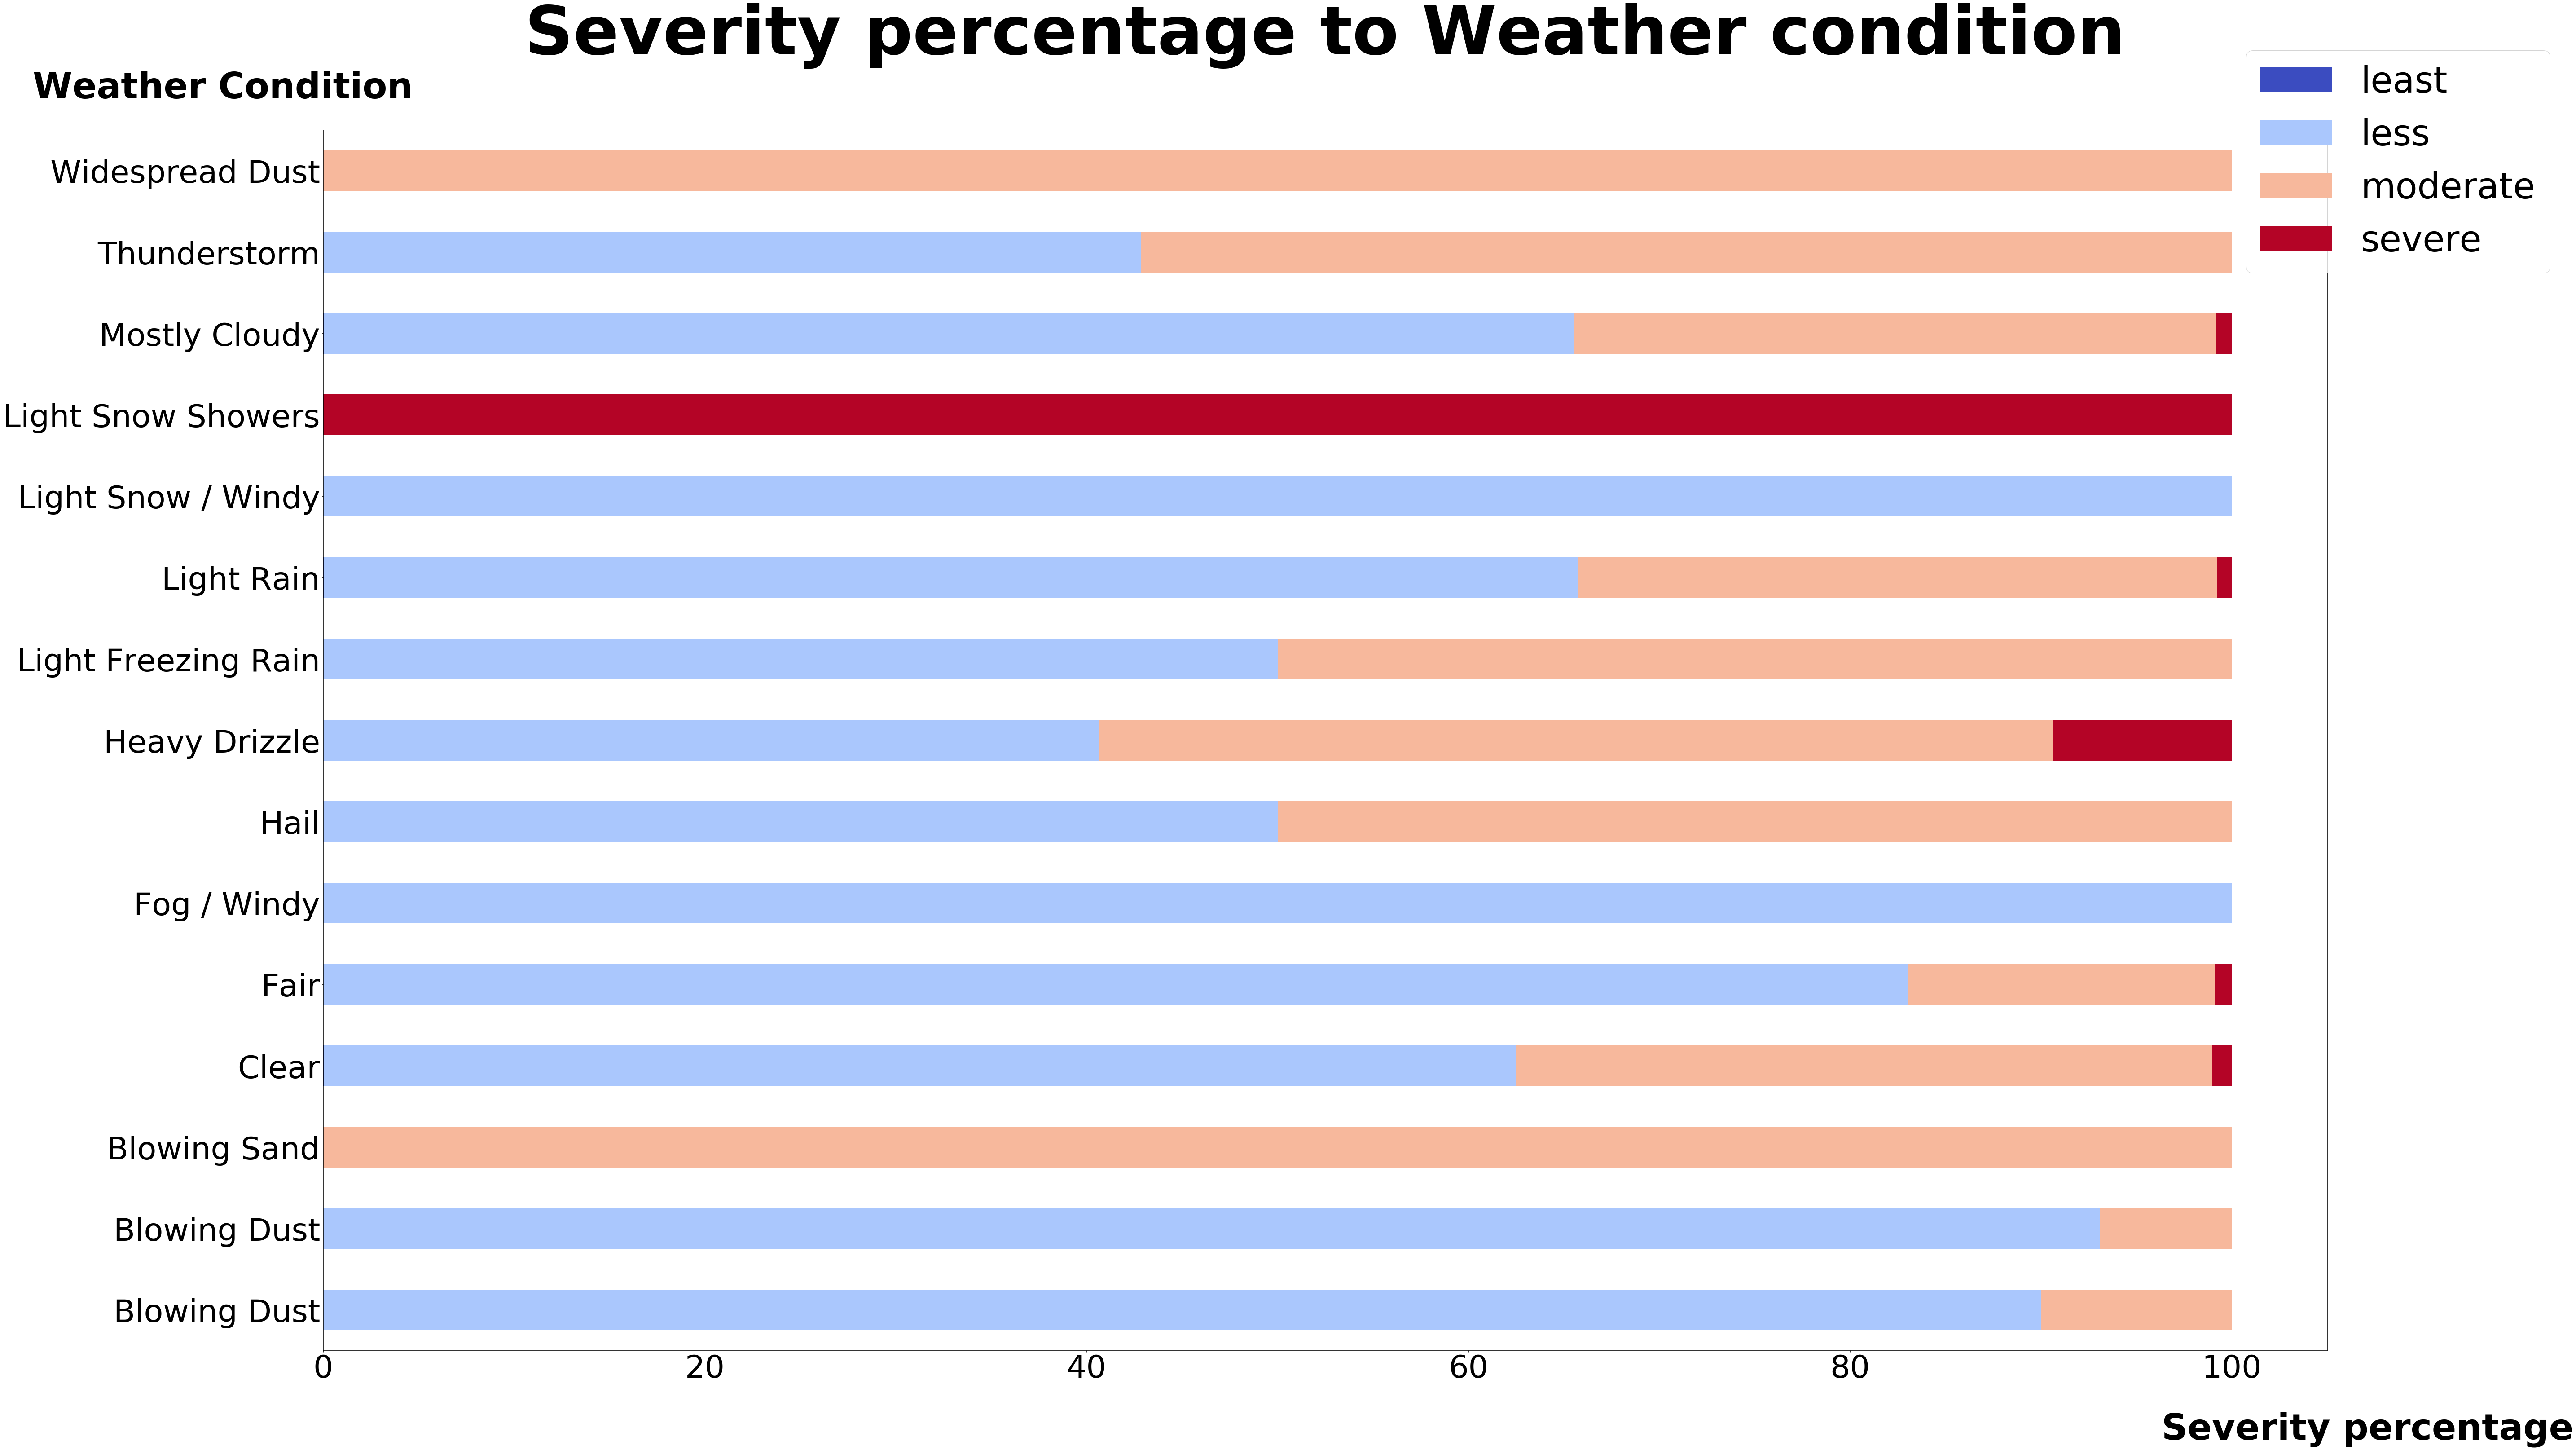

In [28]:
#Plot the stacked bar chart with percentage dataframe which are calculated above
plot_bar_charts(weather_severity_percentage, "Severity percentage to Weather condition", plot_kind="barh", 
        stacked = True, figsize=(80,50), plot_fontsize=70, cmap = "coolwarm", 
        xlabel_name="Severity percentage", xlabel_rotation=0, xlabel_fontsize=80, xlabel_weight='bold', 
        ylabel_name="Weather Condition", ylabel_rotation=0, ylabel_fontsize=80, ylabel_weight='bold', 
        xlabel_coordinate=(1.02, -0.05), ylabel_coordinate=(-0.05, 1.02), title_fontsize=150, 
        title_weight='bold', title_y=1.06, ifledgend=True, ledgend_name=('least', 'less', 'moderate', 'severe'), 
        ledgend_fontsize=80, ledgend_location="upper right", bbox_to_anchor=(1.12, 1.08), frameon=True)

# Analyze California's counties' densities

In [1]:
import numpy as np
from county_ratio import factor1_county
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import csv
from adjustText import adjust_text
from CA_county_density_functions import get_population_CA,get_n_vehicles_CA,get_area_CA,get_n_accidents_CA,data_process_CA
from get_cali_data import get_cali_data

In [2]:
#Separate CA data from US data
get_cali_data('US_Accidents_Dec19.csv')

In [3]:
#get population of each county
population = get_population_CA()

In [4]:
#get number of vehicles of each county
n_vehicles = get_n_vehicles_CA()

In [5]:
#get area of each county
area = get_area_CA()

In [6]:
#get number of accidents in each county
n_accidents = get_n_accidents_CA()

In [7]:
#categorize small samples to 'others', get population, number of vehicles and number of accidents per sq mi
population_per,n_vehicles_per,n_accidents_per = data_process_CA(population,n_vehicles,area,n_accidents)

{'SAN BERNARDINO': 20056.92, 'RIVERSIDE': 7206.47, 'SAN DIEGO': 4206.63, 'LOS ANGELES': 4057.88, 'SANTA CLARA': 1290.1, 'SACRAMENTO': 964.64, 'ORANGE': 790.57, 'ALAMEDA': 739.02, 'CONTRA COSTA': 715.94, 'SAN MATEO': 448.41, 'OTHERS': 115302.51}


In [8]:
#plot
labels = []
population_plot = []
n_vehicles_plot =[]
n_accidents_plot =[]

for key,value in population_per.items():
    labels.append(key)
    population_plot.append(value)
    n_vehicles_plot.append(n_vehicles_per[key])
    n_accidents_plot.append(n_accidents_per[key])



d:\app\python\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


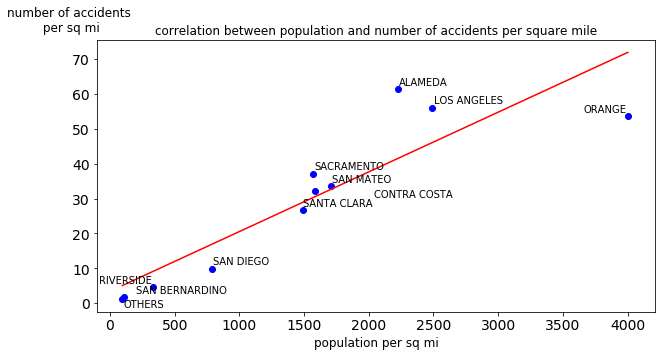

In [9]:
#get scatter plot
fig1 = plt.figure(figsize = (10,5))
texts =[]
for i,county in enumerate(labels):
    x = population_plot[i]
    y = n_accidents_plot[i]
    plt.scatter(x,y,marker = 'o',color = 'blue')
    texts.append(plt.text(x+0.3,y+0.3,county,fontsize = 10))


adjust_text(texts)
coeff1 = np.polyfit(population_plot,n_accidents_plot,1)
poly1d_fn = np.poly1d(coeff1)
plt.plot(population_plot,poly1d_fn(population_plot),'-',color = 'red')
plt.tick_params(axis="both", labelsize=14)
ax = plt.axes()
ax.yaxis.set_label_coords(-0.05,1.02)
plt.title('correlation between population and number of accidents per square mile',fontsize = 12)
plt.xlabel('population per sq mi',fontsize = 12)
plt.ylabel('number of accidents\n per sq mi',fontsize = 12,rotation = 0)

fig1.savefig('pop.png', transparent=True)
plt.show()


d:\app\python\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


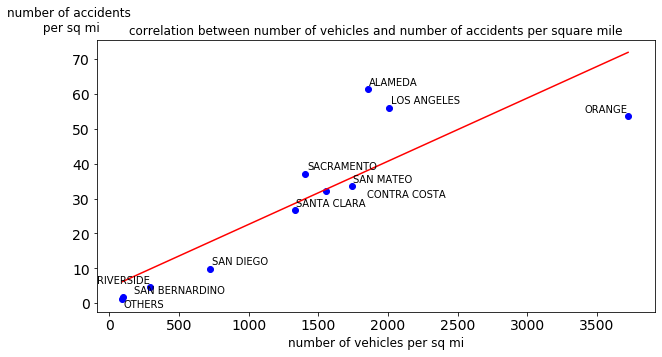

In [10]:
#get scatter plot
fig2 = plt.figure(figsize = (10,5))
texts =[]
for i,county in enumerate(labels):
    x = n_vehicles_plot[i]
    y = n_accidents_plot[i]
    plt.scatter(x,y,marker = 'o',color = 'blue')
    texts.append(plt.text(x+0.3,y+0.3,county,fontsize = 10))

adjust_text(texts)
coeff2 = np.polyfit(n_vehicles_plot,n_accidents_plot,1)
poly1d_fn2 = np.poly1d(coeff2)
plt.plot(n_vehicles_plot,poly1d_fn2(n_vehicles_plot),'-',color = 'red')

plt.tick_params(axis="both", labelsize=14)
ax = plt.axes()
ax.yaxis.set_label_coords(-0.05,1.02)
plt.title('correlation between number of vehicles and number of accidents per square mile',fontsize = 12)
plt.xlabel('number of vehicles per sq mi',fontsize = 12)
plt.ylabel('number of accidents\n per sq mi',fontsize = 12,rotation = 0)
fig2.savefig('vehicle.png', transparent=True)
plt.show()